# DeepShake Multi-step Time Series Forecasting

This notebook is a template for doing time series forecasting on the Ridgecrest dataset

In [2]:
import os
import sys
import py3nvml
sys.path.append("./networks/.")
sys.path.append("../utils/.")

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
#tf.enable_eager_execution()

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(10)

import py3nvml

from utils import *
from lstm import *


In [4]:
print(sys.executable)
!which python

/home/ad9697/anaconda3/envs/tf_gpu/bin/python
/home/ad9697/anaconda3/envs/tf_gpu/bin/python


In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3,4,5,6,7"

# print(py3nvml.grab_gpus(1))

from tensorflow.python.client import device_lib
print (device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 129917292591583446
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16748799761248069383
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 989396992
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 3
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 1287616950310713014
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:07:00.0, compute capability: 3.7"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 989396992
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
    link {
      device_id: 2
      type: "StreamExecutor"
     

In [6]:
!nvidia-smi
py3nvml.grab_gpus(1)


Thu May 14 16:44:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:07:00.0 Off |                    0 |
| N/A   73C    P0   144W / 149W |  10274MiB / 11441MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           On   | 00000000:08:00.0 Off |                    0 |
| N/A   56C    P0   143W / 149W |  10274MiB / 11441MiB |     98%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

1

## The Ridgecrest Dataset and parsed data
This notebook uses a earthquake dataset from Ridgecrest, collected from July to September of 2019.
There are several thousand earthquakes during this time period, which were collected at anywhere from 16-30 stations.

In [7]:
dataset = np.load('../data/acc/compressed/full_data.npy')
print("Before: ", dataset.shape)
#Swap axes
dataset = dataset.swapaxes(1, -1)

#Combine station and xyz
#dataset = dataset.reshape(dataset.shape[0], dataset.shape[1], -1)
print("After: ", dataset.shape)

Before:  (35679, 15, 60)
After:  (35679, 60, 15)


In [8]:
data_path = "../data/histStat_norm_acc"

x_train_multi = np.load(os.path.join(data_path, "X_train_histnorm.npy"))
y_train_multi = np.load(os.path.join(data_path, "y_train_histnorm.npy")) 
x_val_multi = np.load(os.path.join(data_path, "X_val_histnorm.npy"))
y_val_multi = np.load(os.path.join(data_path, "y_val_histnorm.npy"))

y_train_multi = y_train_multi.reshape((y_train_multi.shape[0], -1))
y_val_multi = y_val_multi.reshape((y_val_multi.shape[0], -1))

richters_discrete = np.load(os.path.join(data_path, "richters_discrete.npy"))

In [9]:
print(y_train_multi.max())
np.sum(y_train_multi > 1 * x_train_multi.max())


2914.7723996078616


3621387

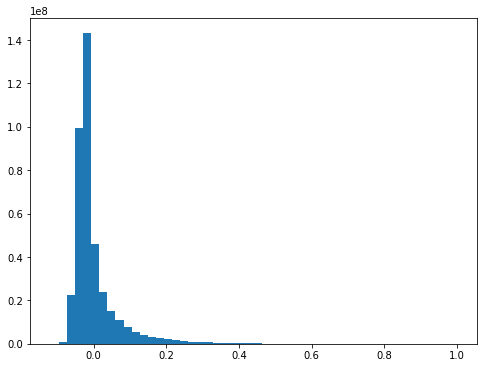

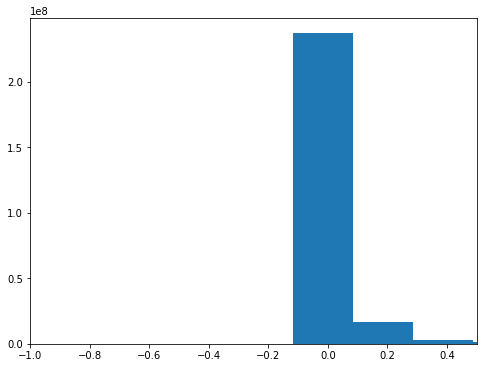

In [18]:
# Distribution of x, y values

plt.hist(x_train_multi.reshape(-1, 1), bins=50)
plt.show()

y_tr_flat = y_train_multi.flatten()
plt.hist(y_tr_flat[y_tr_flat < 10], bins=50)
plt.xlim([-1, .5])
plt.show()

In [13]:
print(x_train_multi.shape)
print(y_train_multi.shape)

print(x_val_multi.shape)
print(y_val_multi.shape)

(1754375, 15, 15)
(1754375, 150)
(249760, 15, 15)
(249760, 150)


In [14]:
import json
config_path = os.path.join(data_path, "config.json")
with open(config_path) as json_file:
    config = json.load(json_file)
    
_, past_history, STEP, future_target, train_distrib, val_distrib = list(config.values())

TRAIN_SPLIT_IDX = sum(train_distrib)

In [15]:
print("Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):")
print("Train set: ", train_distrib)
print("Val set: ", val_distrib)


Distribution of discrete richter magnitudes (<1, 1-3, 3-5, >=5):
Train set:  [8560, 19193, 786, 4]
Val set:  [2168, 4778, 188, 2]


### Multi-Step model
In a multi-step prediction model, given a past history, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predict a sequence of the future.

For the multi-step model, the training data again consists of recordings over the past five days sampled every hour. However, here, the model needs to learn to predict the temperature for the next 12 hours. Since an obversation is taken every 10 minutes, the output is 72 predictions. For this task, the dataset needs to be prepared accordingly, thus the first step is just to create it again, but with a different target window.

In [16]:
# ## Original Definition

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(128,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

multi_step_model.compile(optimizer='nadam', loss='mae', metrics= ['mse', 'mae'])
multi_step_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
Total params: 165,910
Trainable params: 165,910
Non-trainable params: 0
_________________________________________________________________


In [11]:
# ## Time-distributed predictions

# multi_step_model = tf.keras.models.Sequential()
# multi_step_model.add(tf.keras.layers.LSTM(128,
#                                           return_sequences=True,
#                                           input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
# multi_step_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_train_multi.shape[-1]))) #Time-distributes 15 neurons
# # multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

# multi_step_model.compile(optimizer='nadam', loss='mae', metrics= ['mse', 'mae'])
# multi_step_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15, 128)           73728     
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 64)            49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 64)            33024     
_________________________________________________________________
time_distributed (TimeDistri (None, 15, 15)            975       
Total params: 157,135
Trainable params: 157,135
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# ## Original Definition

# multi_step_model = tf.keras.models.Sequential()
# # multistep_model.add(Lambda(lambda x: K.l2_normalize(x,axis=1)))
# multi_step_model.add(tf.keras.layers.LSTM(128,
#                                           return_sequences=True,
#                                           input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'))
# multi_step_model.add(tf.keras.layers.LSTM(64, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(y_train_multi.shape[-1]))

# multi_step_model.compile(optimizer='nadam', loss='mae', metrics= ['mse', 'mae'])
# multi_step_model.summary()

Let's check out a sample data-point.

In [17]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target earthquake signal to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (15, 15)

 Target earthquake signal to predict : (150,)


Plotting a sample data-point.

In [18]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future[:, 0]), 'b--',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction[:, 0]), 'r--',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

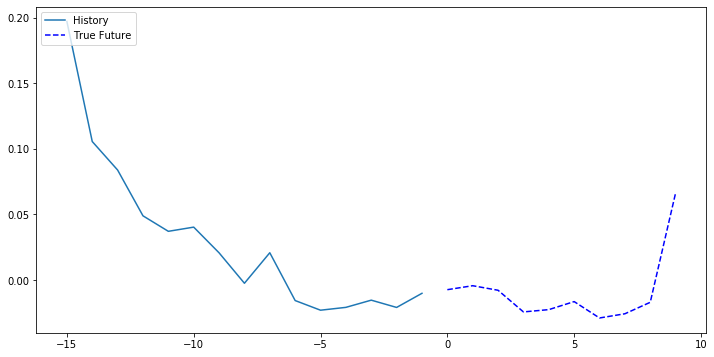

In [19]:
multi_step_plot(x_train_multi[0], y_train_multi[0].reshape(-1, 15), np.array([0]))

In [22]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
from keras import optimizers

lr = .001
BATCH_SIZE=2048
save_path = "./trained_models_acc/multistep"
# cur_file = "LSTM3_10steps_dropzero"
cur_file = 'LSTM_v3'
cur_file = os.path.join(save_path, cur_file)

opt = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)
early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)
model_check = ModelCheckpoint(cur_file + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                              save_weights_only=True, mode='min')
csv_log = CSVLogger(cur_file+ '_history.csv')
callback_list = [early_stop, reduce_lr, model_check, csv_log]


Let's see how the model predicts before it trains.

In [23]:
print(multi_step_model.predict(x_val_multi[0:1], batch_size = BATCH_SIZE).shape)

(1, 150)


In [24]:
EPOCHS = 50
multi_step_history = multi_step_model.fit(x_train_multi, y_train_multi, epochs=EPOCHS,
                                          validation_data=(x_val_multi, y_val_multi), 
                                          batch_size = BATCH_SIZE, callbacks=callback_list)

Train on 1754375 samples, validate on 249760 samples
Epoch 1/50
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.4389 - mse: 106.2697 - mae: 0.4389
Epoch 00001: val_loss improved from inf to 0.05607, saving model to ./trained_models_acc/multistep/LSTM_v3.h5
1754375/1754375 [==============================] - 214s 122us/sample - loss: 0.4388 - mse: 106.2459 - mae: 0.4388 - val_loss: 0.0561 - val_mse: 32.6645 - val_mae: 0.0561
Epoch 2/50
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.4234 - mse: 106.0305 - mae: 0.4234
Epoch 00002: val_loss improved from 0.05607 to 0.05580, saving model to ./trained_models_acc/multistep/LSTM_v3.h5
1754375/1754375 [==============================] - 208s 118us/sample - loss: 0.4233 - mse: 106.0395 - mae: 0.4233 - val_loss: 0.0558 - val_mse: 32.6680 - val_mae: 0.0558
Epoch 3/50
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.4134 - mse: 105.8849 - mae: 0.4134
Epoch 00003: val_loss improved from 0.

Epoch 20/50
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.4032 - mse: 105.8840 - mae: 0.4032
Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 00020: val_loss improved from 0.05178 to 0.05178, saving model to ./trained_models_acc/multistep/LSTM_v3.h5
1754375/1754375 [==============================] - 208s 119us/sample - loss: 0.4032 - mse: 105.8701 - mae: 0.4032 - val_loss: 0.0518 - val_mse: 32.6599 - val_mae: 0.0518
Epoch 21/50
1753088/1754375 [============================>.] - ETA: 0s - loss: 0.4031 - mse: 105.8275 - mae: 0.4031
Epoch 00021: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 00021: val_loss improved from 0.05178 to 0.05178, saving model to ./trained_models_acc/multistep/LSTM_v3.h5
1754375/1754375 [==============================] - 208s 118us/sample - loss: 0.4032 - mse: 105.8699 - mae: 0.4032 - val_loss: 0.0518 - val_mse: 32.6599 - val_mae: 0.0518
Epoch 22/50
1753088/1754375 [=========

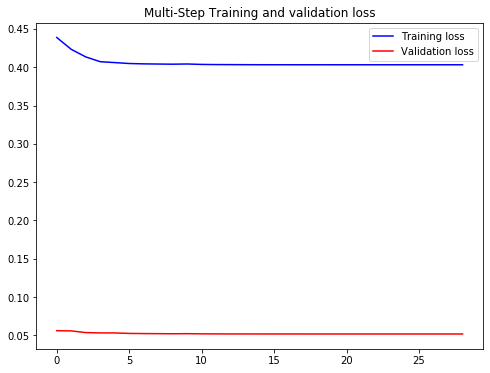

In [25]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

### Evaluate

In [65]:
# np.save(os.path.join(save_path, "X_train_original.npy"), x_train_original)
# np.save(os.path.join(save_path, "y_train_original.npy"), y_train_original)
means = np.load(os.path.join(data_path, "mean_val.npy"))
var = np.load(os.path.join(data_path, "var_val.npy"))
x_val_original = np.load(os.path.join(data_path, "X_val_original.npy"))
y_val_original = np.load(os.path.join(data_path, "y_val_original.npy"))
# print(multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).shape)
y_val_preds = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE)
y_val_preds = np.reshape(y_val_preds, (y_val_original.shape[0], -1, 15))
# y_val_preds = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(-1, int(y_val_original[1]), int(y_val_original[2]))
assert y_val_original.shape == y_val_preds.shape
y_val_original[y_val_original<1e-3] = 1

y_val_preds = y_val_preds * var + means
print("Mean absolute error: ", np.mean(np.abs((y_val_preds / y_val_original) - np.ones_like(y_val_original))))

Mean absolute error:  1.050274315864217


#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

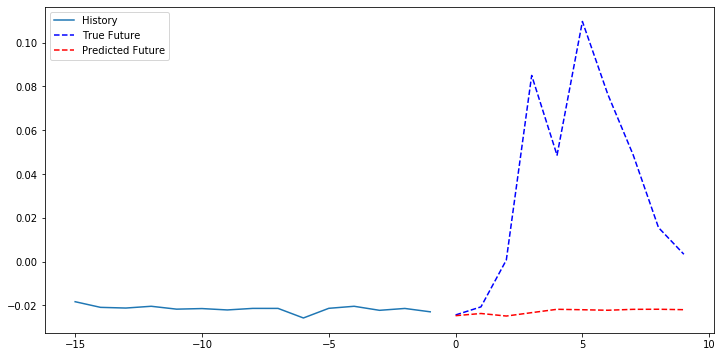

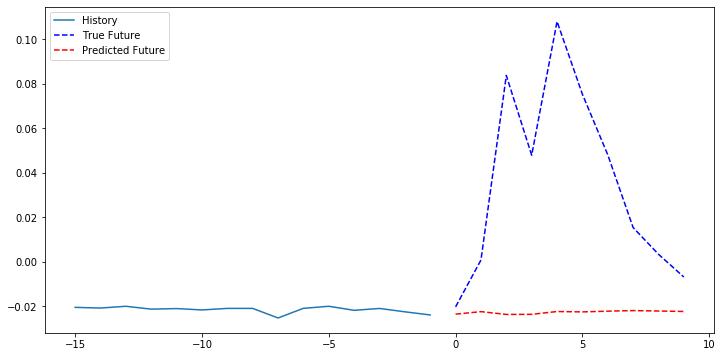

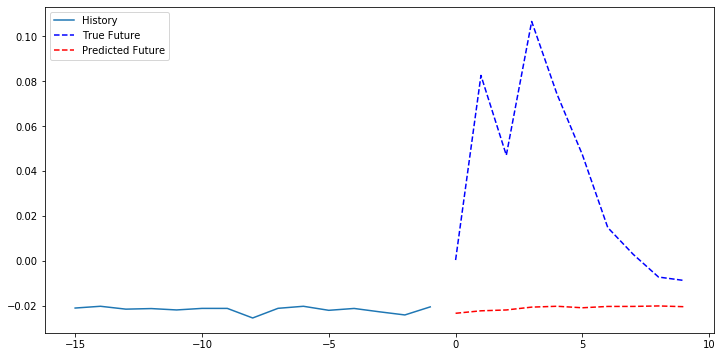

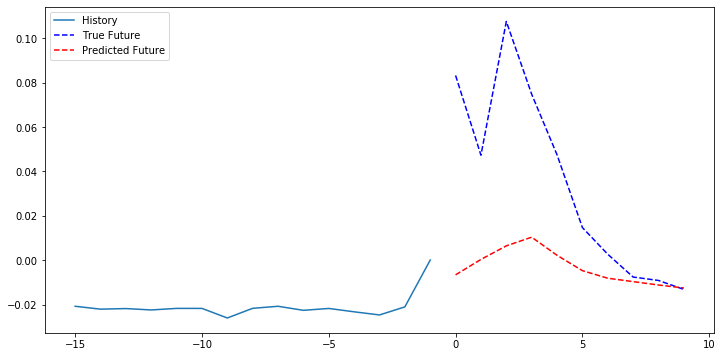

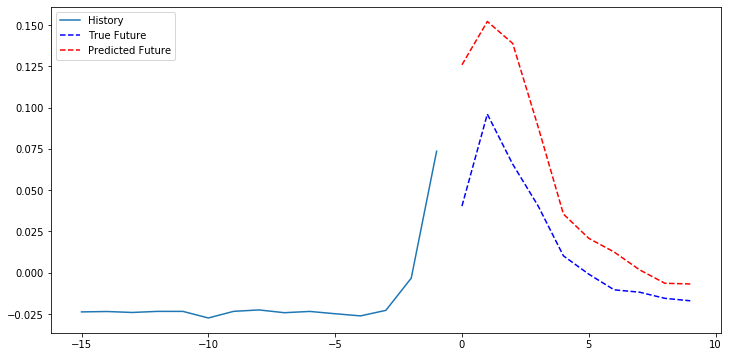

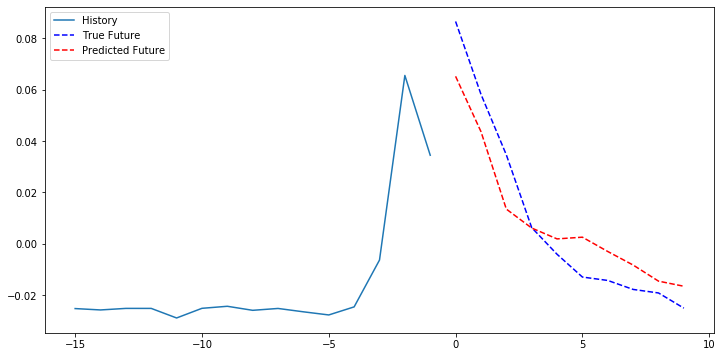

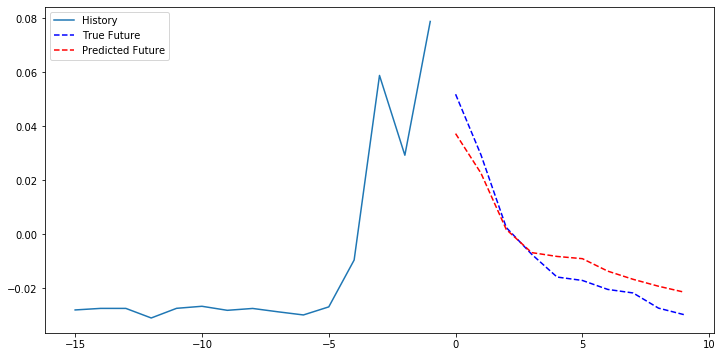

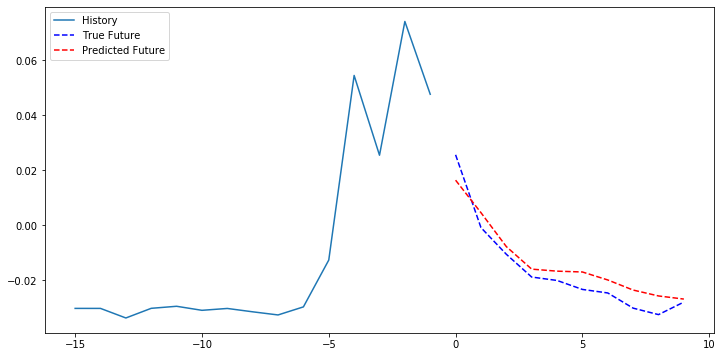

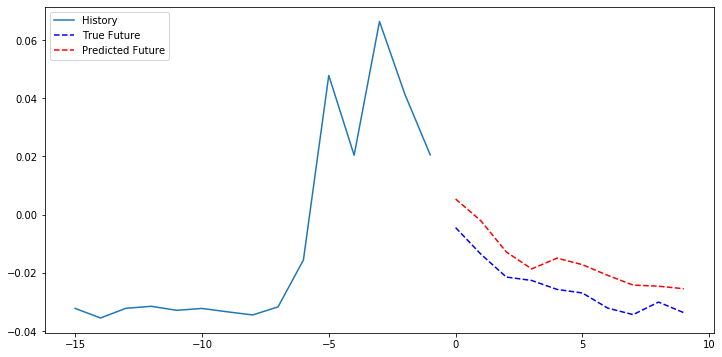

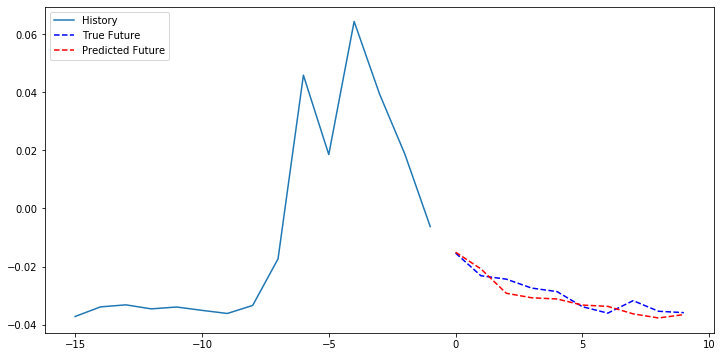

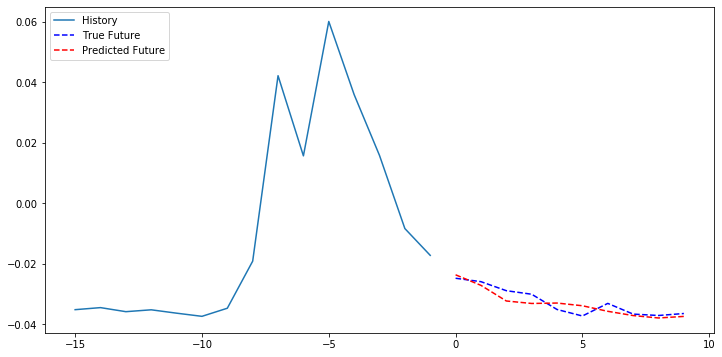

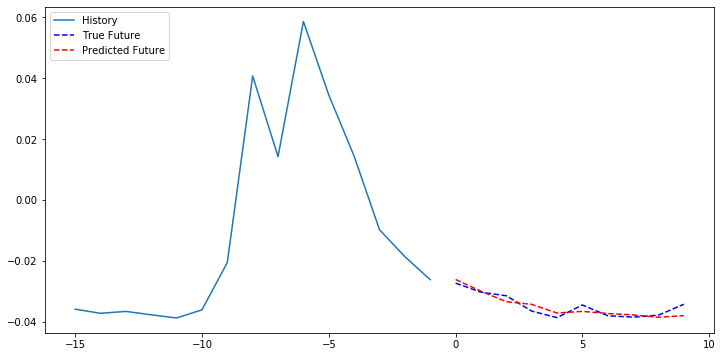

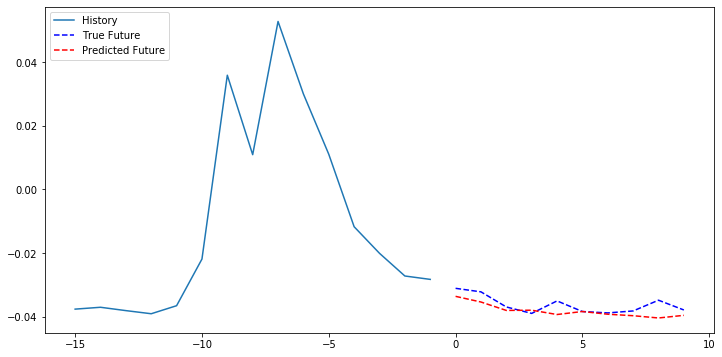

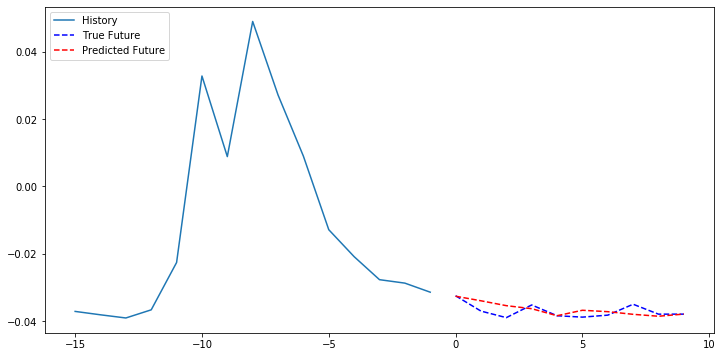

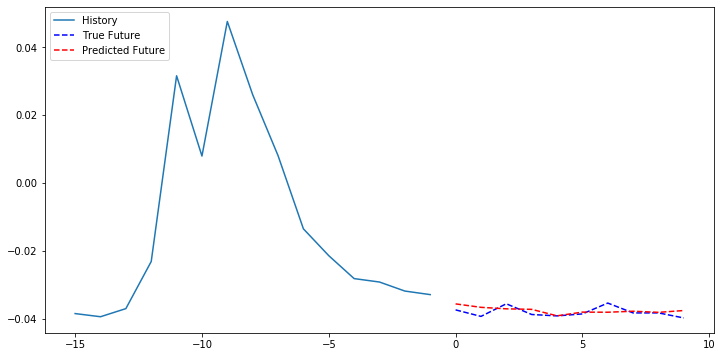

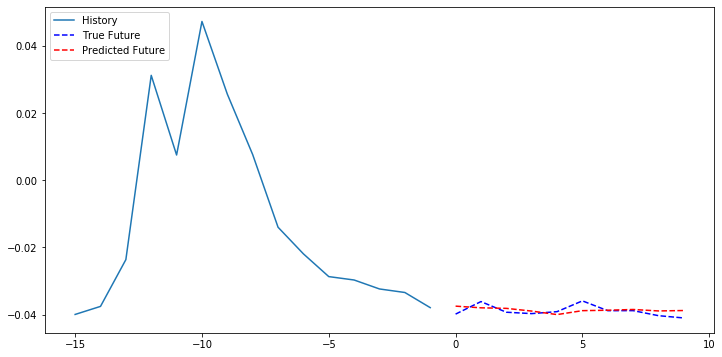

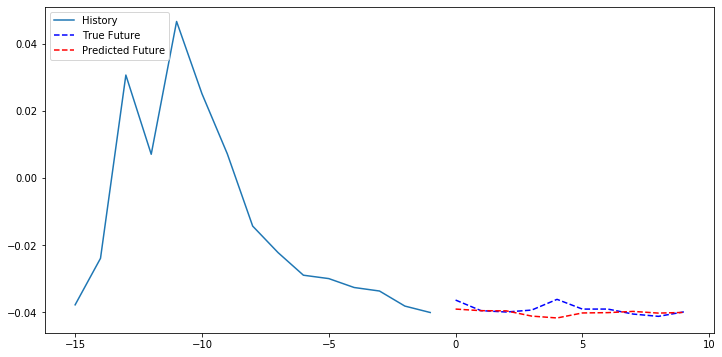

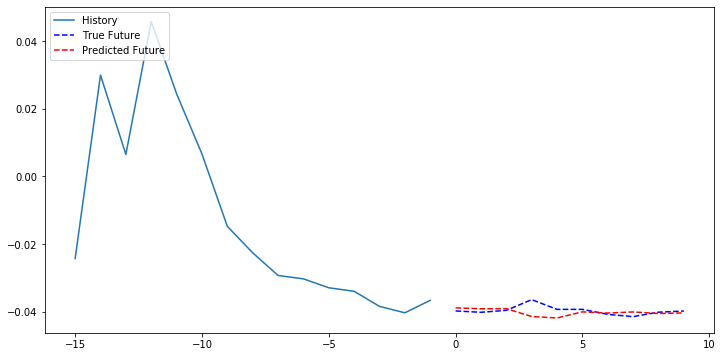

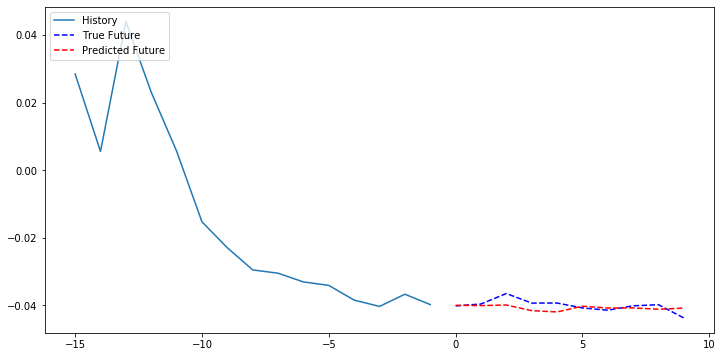

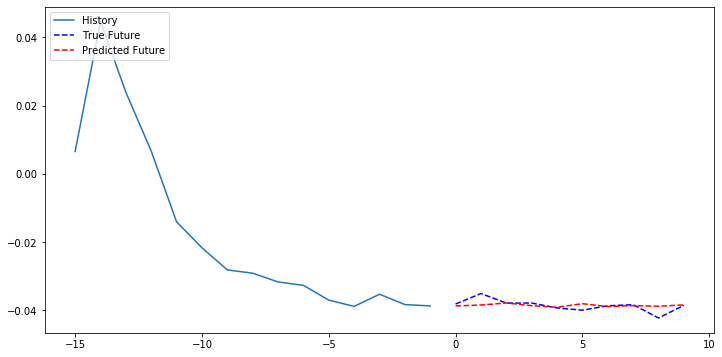

In [29]:
x = x_val_multi[:20]
y = y_val_multi[:20].reshape(len(x), -1, 15)
pred_y = multi_step_model.predict(x).reshape(len(x), -1, 15)
for i in range(20):
    multi_step_plot(x[i], y[i], pred_y[i])

In [50]:
pred_y = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(len(x_val_multi), -1, 15)
pred_y.shape

(285440, 5, 15)

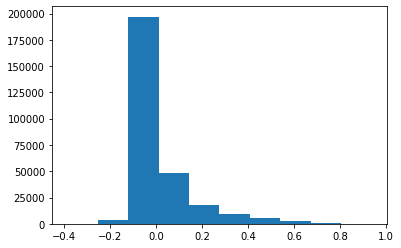

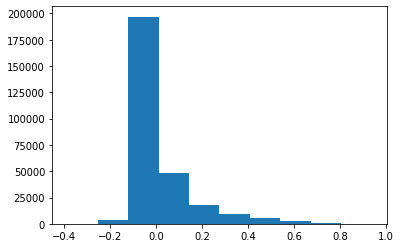

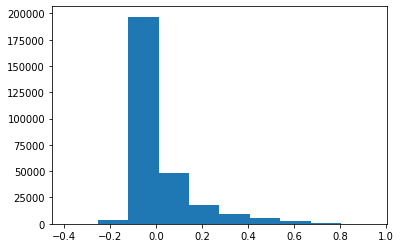

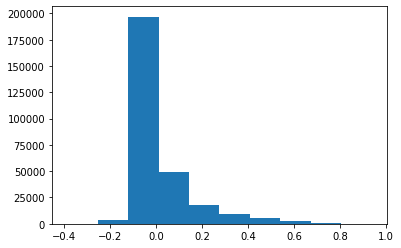

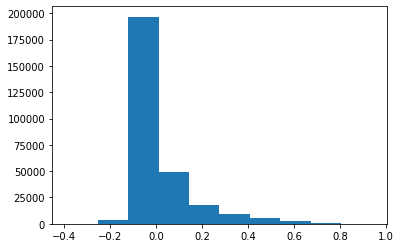

In [51]:
for i in range(5):
    plt.figure()
    data = x_val_multi[:, i, 0]
    data = data[data < 100]
    plt.hist(data)
    plt.show()

# Analyze the predictions of the model

In [68]:
y_pred = multi_step_model.predict(x_val_multi, batch_size = BATCH_SIZE).reshape(-1)
y_true = y_val_multi.reshape(-1)
y_pred.shape, y_true.shape

((37464000,), (37464000,))

In [69]:
from sklearn import metrics

print("Explained Variance Score:", metrics.explained_variance_score(y_true, y_pred)) 
print("Max Error Score:", metrics.max_error(y_true, y_pred)) 
print("Mean Absolute Error Score:", metrics.mean_absolute_error(y_true, y_pred)) 
print("Mean Squared Error Score:", metrics.mean_squared_error(y_true, y_pred)) 
print("Median Absolute Error Score:", metrics.median_absolute_error(y_true, y_pred)) 
print("R2 Score:", metrics.r2_score(y_true, y_pred)) 

Explained Variance Score: 0.10454345324355963
Max Error Score: 914.403525737854
Mean Absolute Error Score: 0.01502740796828705
Mean Squared Error Score: 0.27150597970265855
Median Absolute Error Score: 3.647820449200466e-05
R2 Score: 0.1044396223817986
